In [878]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

In [879]:
df = pd.read_csv("rfm_result.csv")
df.head()

,customerid,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,segment
0,13298,0.0,1,360.00,1,4,4,144,At Risk
1,17144,0.0,2,984.57,1,3,2,132,Others
2,13077,0.0,4,728.02,1,2,3,123,Hibernating
3,16688,0.0,4,1260.86,1,2,2,122,Hibernating
4,14621,0.0,5,1788.36,1,2,2,122,Hibernating


In [880]:
df["segment"].value_counts()

segment
Others                1182
Hibernating           1110
Champions              904
Loyal Customers        535
At Risk                312
Potential Loyalist     295
Name: count, dtype: int64

In [881]:
# Map segment names to numeric codes
mapping = {
    'Others': 6,
    'Hibernating': 5,
    'Champions': 1,
    'Loyal Customers': 2,
    'At Risk': 4,
    'Potential Loyalist': 3
}

# Replace textual segment with numeric codes (nullable integer to preserve unmapped)
df['segment'] = df['segment'].map(mapping).astype('Int64')

# Quick check
print(df['segment'].value_counts(dropna=False))

segment
6    1182
5    1110
1     904
2     535
4     312
3     295
Name: count, dtype: Int64


In [882]:
df.columns

Index(['customerid', 'recency', 'frequency', 'monetary', 'r_score', 'f_score',
       'm_score', 'rfm_score', 'segment'],
      dtype='object')

In [883]:
df.isnull().sum()

customerid    0
recency       0
frequency     0
monetary      0
r_score       0
f_score       0
m_score       0
rfm_score     0
segment       0
dtype: int64

In [884]:
df = df[
    (df["frequency"] > 0) &
    (df["monetary"] > 0)
]

In [885]:
scaler = RobustScaler()

rfm_scaled = scaler.fit_transform(
    df[["recency", "frequency", "monetary"]]
)

rfm_scaled = pd.DataFrame(
    rfm_scaled,
    columns=["recency", "frequency", "monetary"]
)
rfm_scaled.head()

,recency,frequency,monetary
0,-0.403226,-0.25,-0.222497
1,-0.403226,0.00,0.242642
2,-0.403226,0.50,0.051580
3,-0.403226,0.50,0.448405
4,-0.403226,0.75,0.841252


# Elbow Method

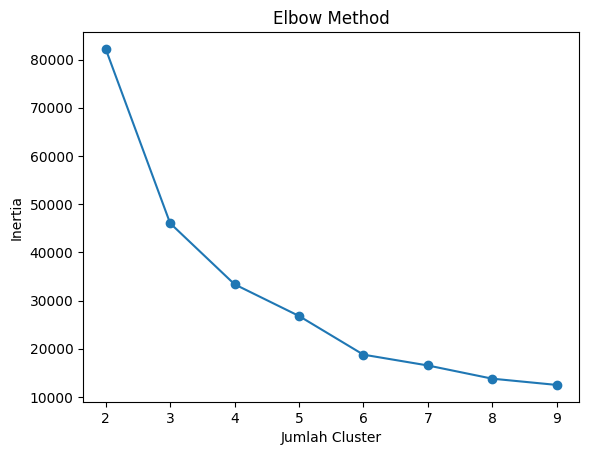

In [886]:
inertia = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker="o")
plt.xlabel("Jumlah Cluster")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

# Modelling

In [887]:
kmeans = KMeans(n_clusters=4, random_state=123)
df["cluster"] = kmeans.fit_predict(rfm_scaled)

df.head()

,customerid,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,segment,cluster
0,13298,0.0,1,360.00,1,4,4,144,4,0
1,17144,0.0,2,984.57,1,3,2,132,6,0
2,13077,0.0,4,728.02,1,2,3,123,5,0
3,16688,0.0,4,1260.86,1,2,2,122,5,0
4,14621,0.0,5,1788.36,1,2,2,122,5,0


In [888]:
score = silhouette_score(rfm_scaled, df["cluster"])
score

np.float64(0.8153001008722544)

In [889]:
cluster_summary = df.groupby("cluster").agg({
    "recency": "mean",
    "frequency": "mean",
    "monetary": "mean",
    "customerid": "count"
}).rename(columns={"customerid": "jumlah_customer"})

cluster_summary

,recency,frequency,monetary,jumlah_customer
cluster,,,,
0,94.471110,3.353153,1130.825589,4171
1,2.000000,45.250000,225681.652500,4
2,27.062500,51.937500,76302.740625,16
3,17.721088,24.034014,13634.819116,147


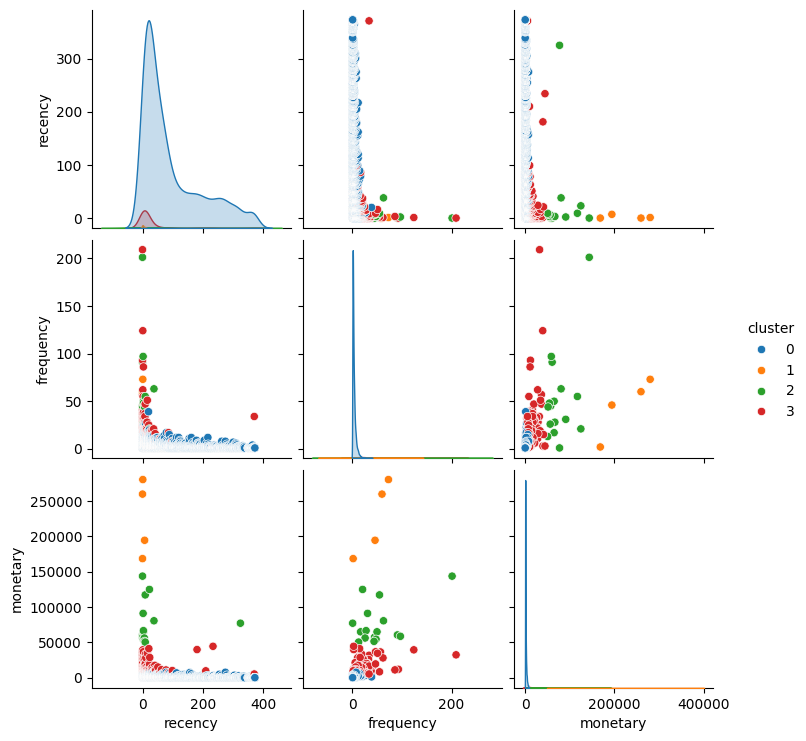

In [890]:
sns.pairplot(
    df,
    vars=["recency", "frequency", "monetary"],
    hue="cluster",
    palette="tab10"
)
plt.show()

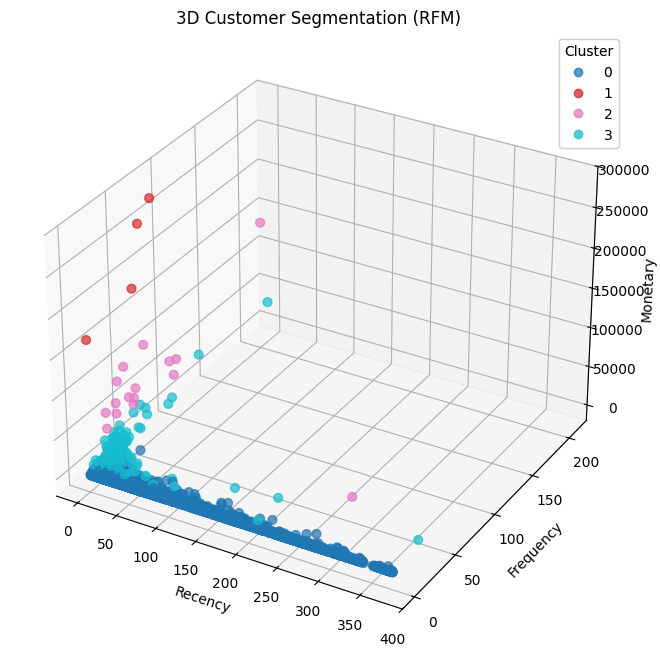

In [891]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

scatter = ax.scatter(
    df["recency"],
    df["frequency"],
    df["monetary"],
    c=df["cluster"],
    cmap="tab10",
    s=40,
    alpha=0.7
)

ax.set_xlabel("Recency")
ax.set_ylabel("Frequency")
ax.set_zlabel("Monetary")
ax.set_title("3D Customer Segmentation (RFM)")

legend = ax.legend(
    *scatter.legend_elements(),
    title="Cluster"
)
ax.add_artist(legend)

plt.show()